In [1]:
library(wesanderson)
library(purrr)
library(ggthemes)
library(bayesplot)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(cowplot)
library(ggbeeswarm)
library(tidybayes)
library(rethinking)
#set_ulam_cmdstan(TRUE)
#data(chimpanzees)
#d <- chimpanzees
#detach(package:rethinking, unload = T)
library(brms)
library(performance)

This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ readr     2.1.4     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubrida

In [2]:
theme_set(
  theme_base(base_size = 12) +
    theme(text = element_text(family = "Times"),
          axis.text = element_text(family = "Times"),
          axis.ticks = element_line(linewidth = 0.25),
          axis.ticks.length = unit(0.1, "cm"),
          panel.background = element_rect(linewidth = 0.1),
          plot.background = element_blank(),
          )
  )

In [3]:
setwd("~/Documents/post-doc/cingulata/research/crossings/")
datalist = readRDS("modeldatasets.RDS")

`summarise()` has grouped output by 'cross_type'. You can override using the
`.groups` argument.


cross_type,pop,egg_tot
<chr>,<chr>,<int>
FMpos_wCer1,different,545
FMpos_wCer1,same,641
Fpos_wCer1,different,242
Fpos_wCer1,same,140
Mpos_wCer1,different,282
Mpos_wCer1,same,297
bothNeg_wCer1,different,522
bothNeg_wCer1,same,490


cross_type,Mean
<chr>,<dbl>
FMpos_wCer1,0.2442927
Fpos_wCer1,0.2338068
Mpos_wCer1,0.3909116
bothNeg_wCer1,0.2543331


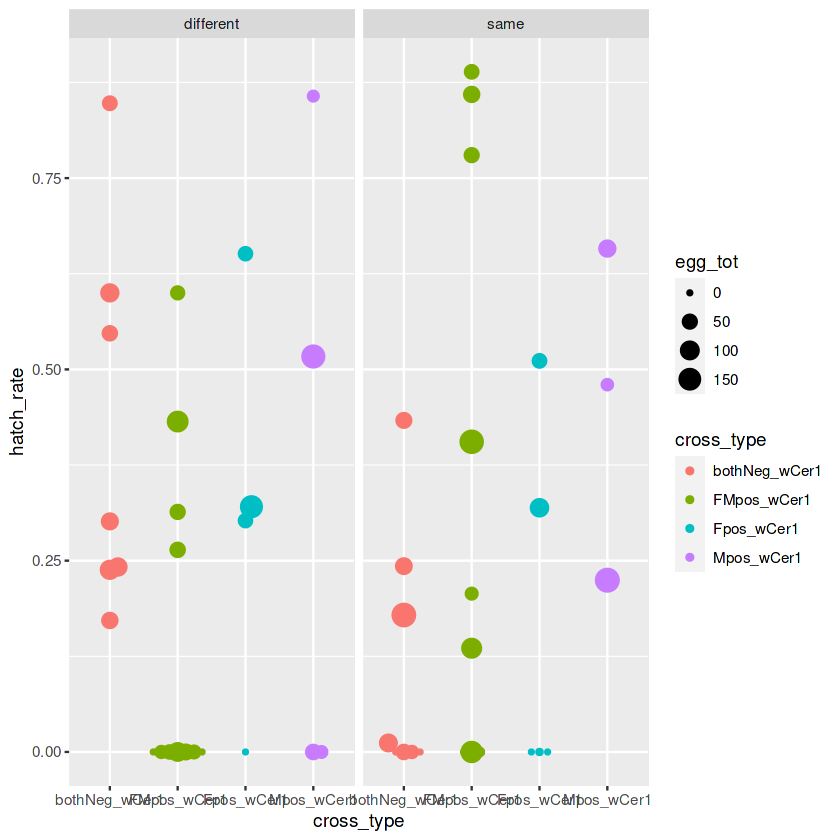

In [3]:
d.eu <- read.csv("~/Documents/post-doc/cingulata/research/crossings/crossing_data_ordered.csv", header = T, sep = ",")
# Carfefull with cage 20. Infection unknown
d.eu$hatch_rate <- d.eu$hatched/d.eu$egg_tot
d.eu[d.eu$hatch_rate == "NaN",]$hatch_rate <- 0
d.eu %>% group_by(cross_type, pop) %>% summarise(egg_tot = sum(egg_tot))
d.eu %>%  group_by(cross_type) %>% dplyr::summarize(Mean = mean(hatch_rate, na.rm=TRUE))
d.eu <- d.eu %>% 
    mutate(cross_type = case_when(infection_F == 0 & infection_M == 0 ~ "bothNeg_wCer1" , # both tests: group A
                                  infection_F == 0 & infection_M == 1 ~ "Mpos_wCer1",
                                  infection_F == 1 & infection_M == 0 ~ "Fpos_wCer1",
                                  infection_F == 1 & infection_M == 1 ~ "FMpos_wCer1"

    ))

d.eu <- d.eu %>% 
    mutate(pop = case_when(population_F == population_M ~  "same", # both tests: group A
                                population_F != population_M ~  "different"
    ))

d.eu <- d.eu %>% add_column(continent = "europe")

d.eu.egg.filter <- d.eu %>% filter(egg_tot > 5)

ENP.eu <- ggplot(d.eu, aes(x = cross_type, y = egg_tot, color = cross_type, size = egg_tot)) + geom_beeswarm(cex = 3) + facet_wrap(~pop)
HRP.eu <- ggplot(d.eu, aes(x = cross_type, y = hatch_rate, color = cross_type, size = egg_tot)) + geom_beeswarm(cex = 3) + facet_wrap(~pop)
HNP.eu <- ggplot(d.eu, aes(x = cross_type, y = hatched, color = cross_type, size = egg_tot)) + geom_beeswarm(cex = 3) + facet_wrap(~pop)
#plot_grid(ENP.eu, HNP.eu, HRP.eu)
plot_grid(HRP.eu)

In [4]:
b1.0 <- datalist$b1.0
b1.1 <- datalist$b1.1
b1.2 <- datalist$b1.2
b1.3 <- datalist$b1.3
b1.4 <- datalist$b1.4
b1.5 <- datalist$b1.5

In [6]:
b1.0 <- add_criterion(b1.0, "waic")
b1.1 <- add_criterion(b1.1, "waic")
b1.2 <- add_criterion(b1.2, "waic")
b1.3 <- add_criterion(b1.3, "waic")
b1.4 <- add_criterion(b1.4, "waic")
b1.5 <- add_criterion(b1.5, "waic")

w <- loo_compare(b1.0, b1.1, b1.2, b1.3, b1.4, b1.5, criterion = "waic")

print(w, simplify = F)

     elpd_diff se_diff elpd_waic se_elpd_waic p_waic se_p_waic waic   se_waic
b1.4    0.0       0.0  -102.6       9.4         20.2    1.3     205.3   18.7 
b1.5   -0.2       0.4  -102.8       9.3         20.3    1.3     205.6   18.7 
b1.3   -0.3       0.4  -103.0       9.4         20.5    1.3     205.9   18.7 
b1.0   -1.1       0.6  -103.8       9.3         20.9    1.4     207.5   18.7 
b1.1   -1.1       0.6  -103.8       9.3         20.9    1.4     207.5   18.7 
b1.2   -1.3       0.5  -104.0       9.3         21.1    1.4     207.9   18.7 


Setting all 'trials' variables to 1 by default if not specified otherwise.



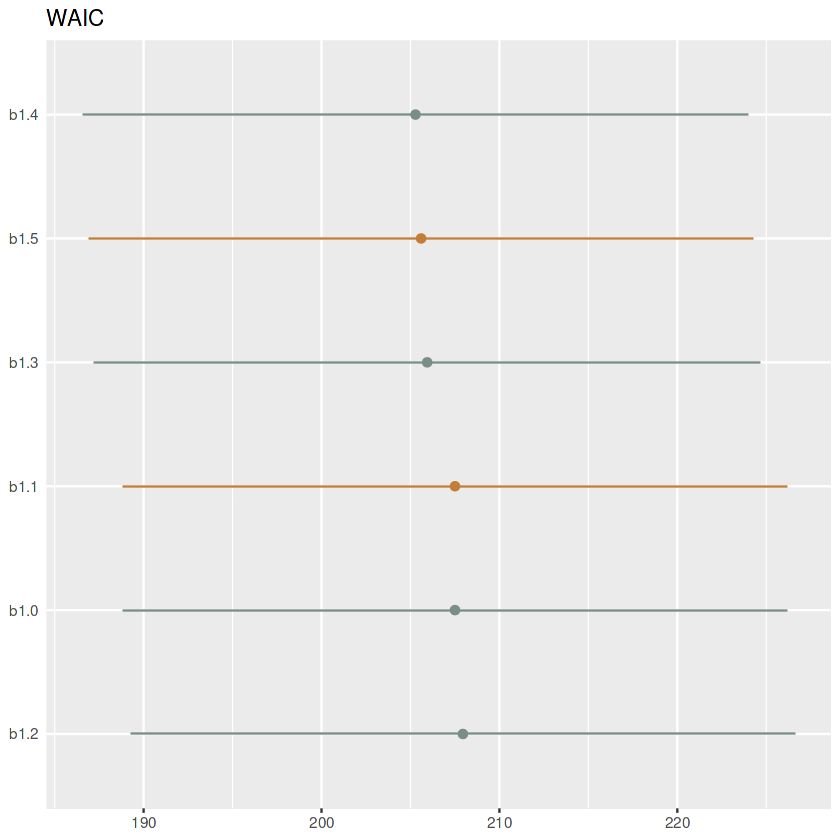

Setting all 'trials' variables to 1 by default if not specified otherwise.



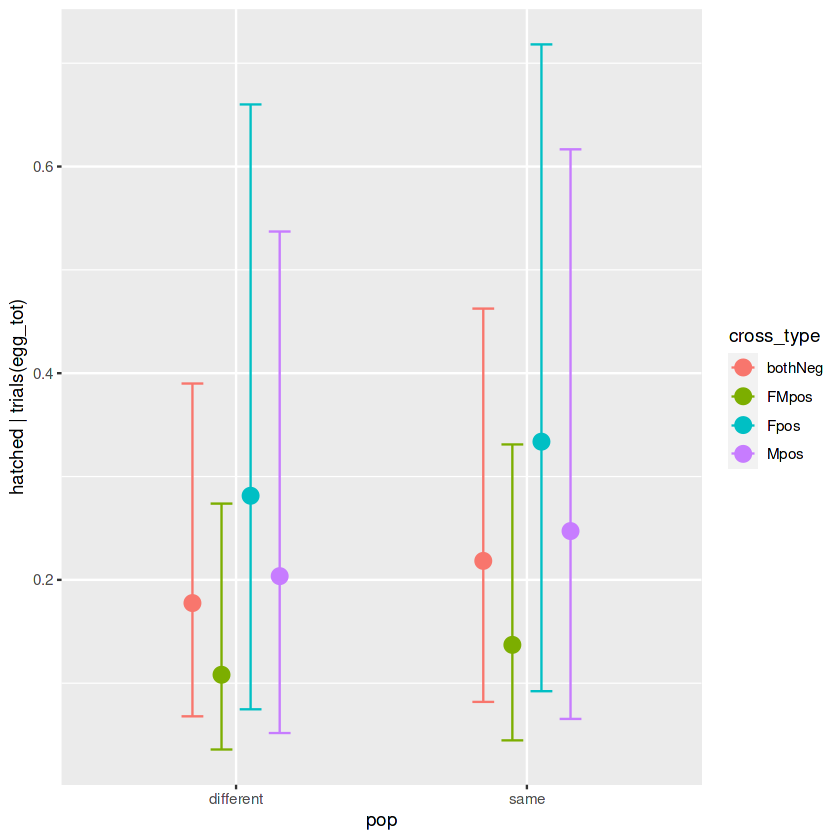

Using 10 posterior draws for ppc type 'dens_overlay' by default.



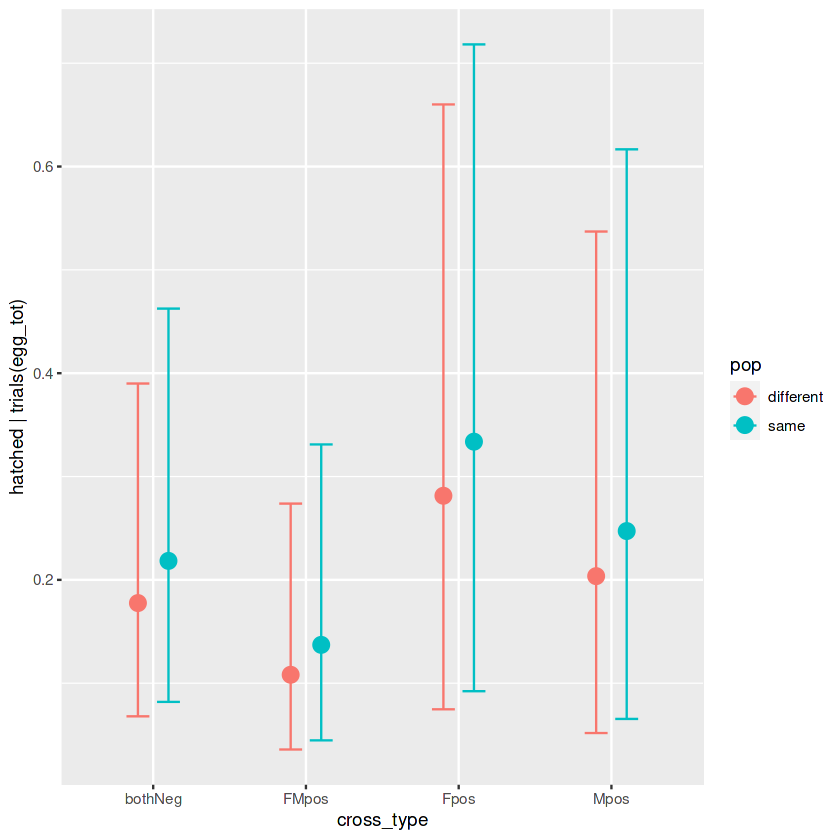

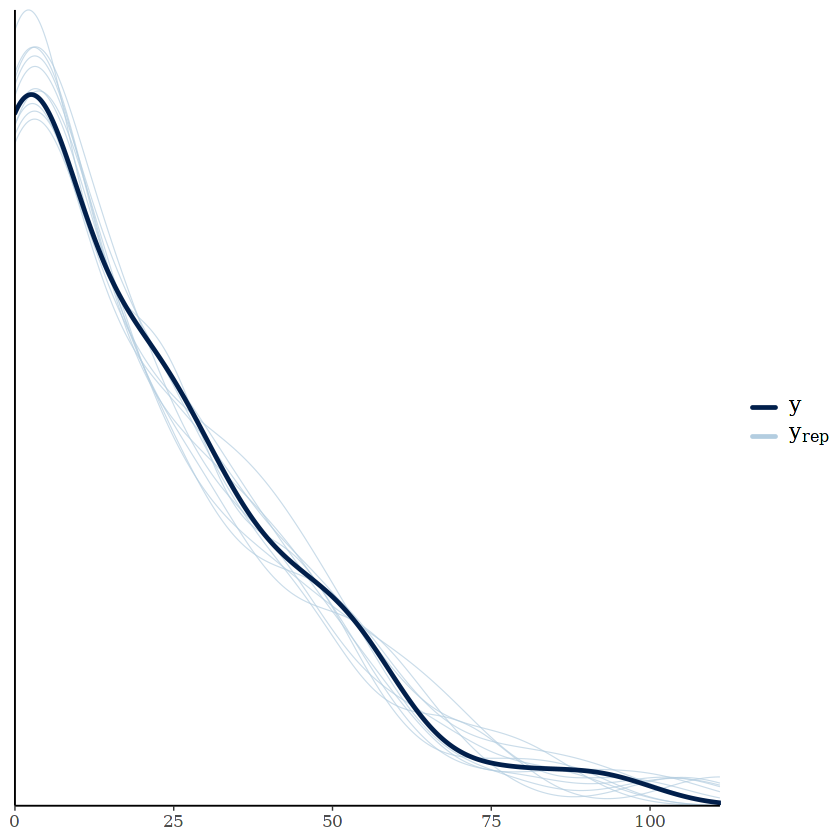

In [10]:
w %>% 
  data.frame() %>% 
  rownames_to_column(var = "model") %>%
  
  ggplot(aes(x = reorder(model, -waic), 
             y    = waic,
             ymin = waic - se_waic,
             ymax = waic + se_waic,
             color = model)) +
  geom_pointrange(shape = 16, show.legend = F) +
  scale_color_manual(values = wes_palette("Moonrise2")[c(1, 2, 1, 1, 1, 2)]) +
  coord_flip() +
  labs(x = NULL, y = NULL,
       title = "WAIC") +
  theme(axis.ticks.y    = element_blank())

# mcmc_pairs(x = posterior_samples(b1.3),
#            pars = c("b_Intercept", "b_prosoc_left", "b_prosoc_left:condition"),
#            off_diag_args = list(size = 1/10, alpha = 1/6),
#            diag_fun = "dens")

conditional_effects(b1.4, effects = "pop:cross_type", prob = 0.89)
conditional_effects(b1.4, effects = "cross_type:pop", prob = 0.89)
pp_check(b1.4, type = "dens_overlay")

Using 10 posterior draws for ppc type 'dens_overlay' by default.



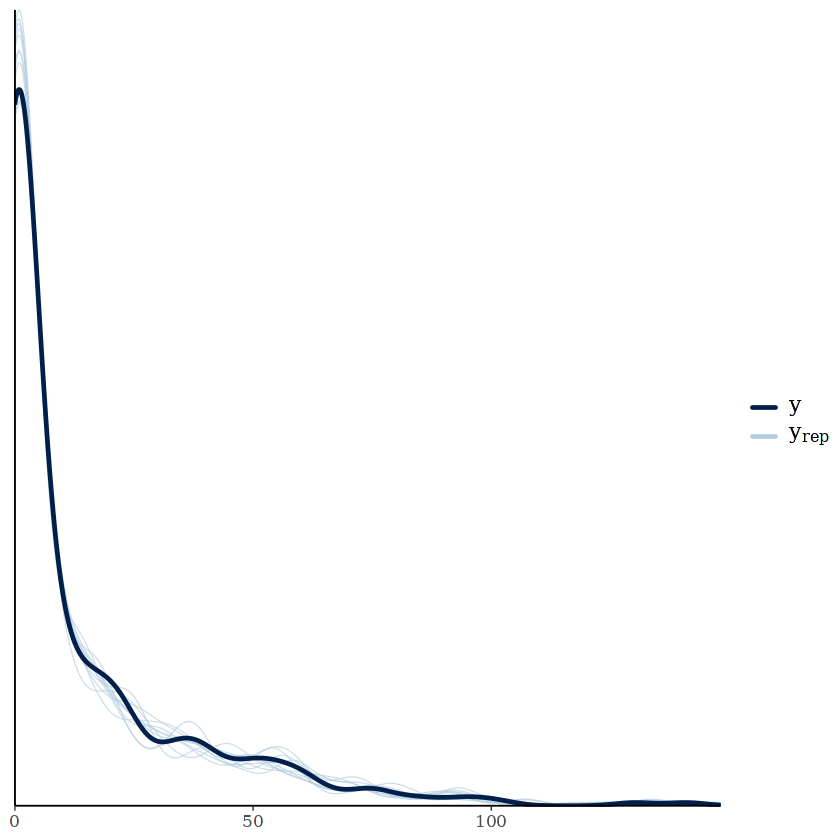

In [15]:
pp_check(b2.1, type = "dens_overlay")

In [ ]:
col_pickup <- c('b_Intercept','b_cross_typeFMpos','b_cross_typeFpos','b_cross_typeMpos')
post1.4 <- as_draws_df(b1.4) %>% #select(all_of(col_pickup)) %>% 
pivot_longer(col_pickup) %>%
  mutate(cross_type = case_when(
    startsWith(name, "b_Intercept") ~ "bothNeg",
    startsWith(name, "b_cross_typeFMpos") ~ "FMpos",
    startsWith(name, "b_cross_typeFpos") ~ "Fpos",
    startsWith(name, "b_cross_typeMpos") ~ "Mpos"
    )) 

In [129]:
post1.4

b_popsame,sd_id__Intercept,"r_id[2,Intercept]","r_id[4,Intercept]","r_id[5,Intercept]","r_id[6,Intercept]","r_id[8,Intercept]","r_id[9,Intercept]","r_id[11,Intercept]","r_id[12,Intercept]",⋯,"r_id[80,Intercept]","r_id[81,Intercept]",lprior,lp__,.chain,.iteration,.draw,name,value,cross_type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>,<chr>
-0.4027111,2.294083,-0.7138889,-2.149025,-1.04151867,0.01040196,-0.1173162,-1.6026780,0.799464085,-3.593752,⋯,-3.447139,-4.395018,-9.673238,-161.9922,1,1,1,b_Intercept,-1.01303355,bothNeg
-0.4027111,2.294083,-0.7138889,-2.149025,-1.04151867,0.01040196,-0.1173162,-1.6026780,0.799464085,-3.593752,⋯,-3.447139,-4.395018,-9.673238,-161.9922,1,1,1,b_cross_typeFMpos,-0.38551165,FMpos
-0.4027111,2.294083,-0.7138889,-2.149025,-1.04151867,0.01040196,-0.1173162,-1.6026780,0.799464085,-3.593752,⋯,-3.447139,-4.395018,-9.673238,-161.9922,1,1,1,b_cross_typeFpos,2.01820747,Fpos
-0.4027111,2.294083,-0.7138889,-2.149025,-1.04151867,0.01040196,-0.1173162,-1.6026780,0.799464085,-3.593752,⋯,-3.447139,-4.395018,-9.673238,-161.9922,1,1,1,b_cross_typeMpos,0.91526965,Mpos
-0.1678056,2.201091,-0.7562261,-2.254919,0.56766956,-0.77788823,-0.4631672,-1.2573244,0.562249096,-3.605432,⋯,-3.229611,-3.083800,-9.636268,-171.0578,1,2,2,b_Intercept,-1.28966430,bothNeg
-0.1678056,2.201091,-0.7562261,-2.254919,0.56766956,-0.77788823,-0.4631672,-1.2573244,0.562249096,-3.605432,⋯,-3.229611,-3.083800,-9.636268,-171.0578,1,2,2,b_cross_typeFMpos,0.01557797,FMpos
-0.1678056,2.201091,-0.7562261,-2.254919,0.56766956,-0.77788823,-0.4631672,-1.2573244,0.562249096,-3.605432,⋯,-3.229611,-3.083800,-9.636268,-171.0578,1,2,2,b_cross_typeFpos,2.01514907,Fpos
-0.1678056,2.201091,-0.7562261,-2.254919,0.56766956,-0.77788823,-0.4631672,-1.2573244,0.562249096,-3.605432,⋯,-3.229611,-3.083800,-9.636268,-171.0578,1,2,2,b_cross_typeMpos,1.07419855,Mpos
1.0540492,2.708417,-1.3313479,-2.823978,-0.51553702,-1.14933743,-0.1892213,-2.2452066,-1.442547013,-1.699583,⋯,-2.906224,-3.237855,-10.455339,-166.9545,1,3,3,b_Intercept,-2.09709764,bothNeg


Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


<ggproto object: Class FacetWrap, Facet, gg>
    compute_layout: function
    draw_back: function
    draw_front: function
    draw_labels: function
    draw_panels: function
    finish_data: function
    init_scales: function
    map_data: function
    params: list
    setup_data: function
    setup_params: function
    shrink: TRUE
    train_scales: function
    vars: function
    super:  <ggproto object: Class FacetWrap, Facet, gg>

Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”


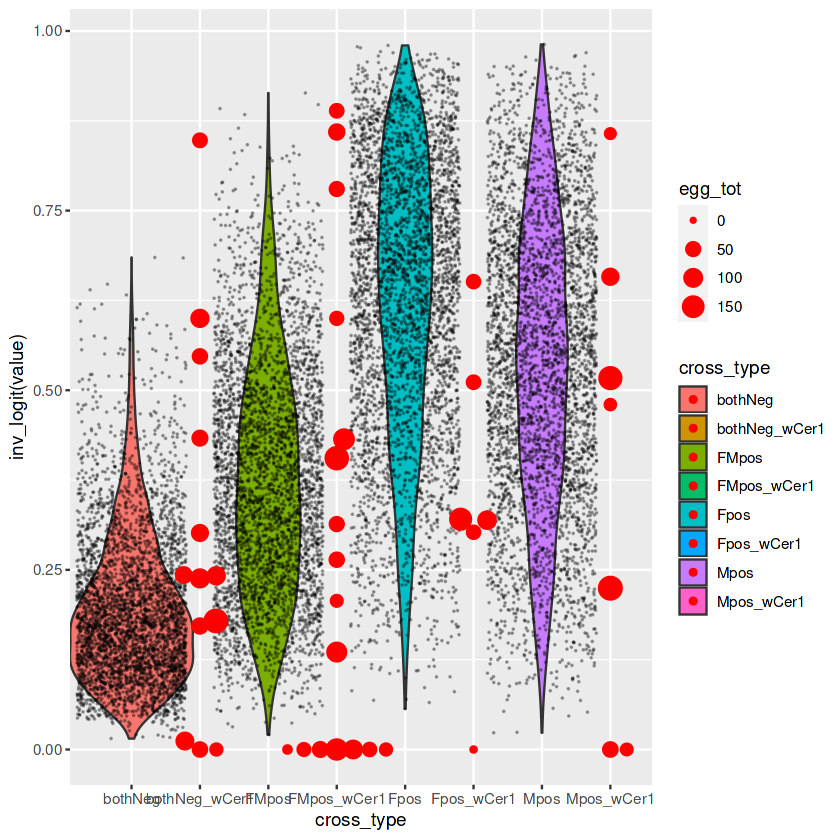

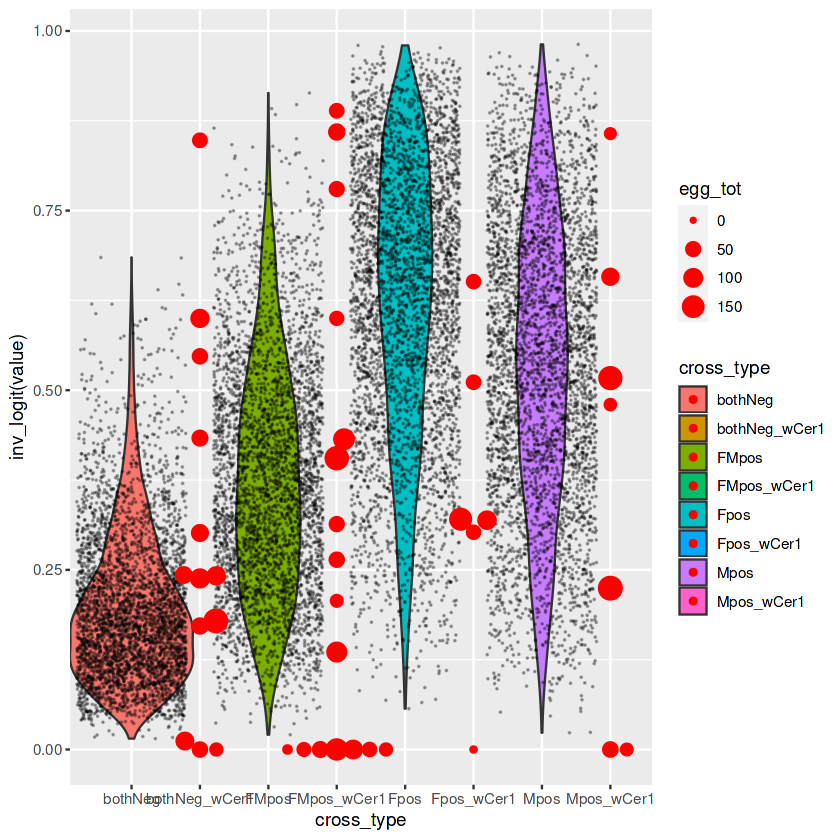

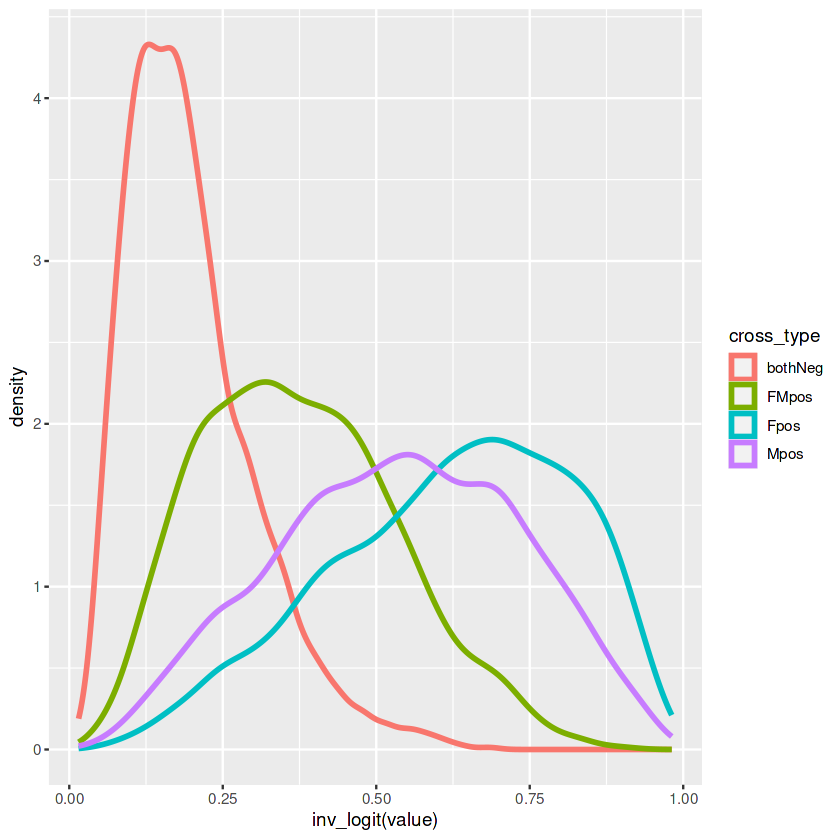

In [128]:
ggplot(data = post1.4, aes(x=cross_type, y=inv_logit(value), fill=cross_type)) +
    geom_violin() +
    geom_jitter(color="black", size=0.004, alpha=0.3) +
    geom_beeswarm(data = d.eu, aes(x=cross_type, y=hatched/egg_tot, size = egg_tot), color = "red", cex= 3)
    facet_wrap(~pop, ncol = 2)
  ggplot(data = post1.4, aes(x=cross_type, y=inv_logit(value), fill=cross_type)) +
    geom_violin() +
    geom_jitter(color="black", size=0.004, alpha=0.3) + geom_beeswarm(data = d.eu, aes(x=cross_type, y=hatched/egg_tot, size = egg_tot), color = "red", cex= 3)
  

ggplot(data = post1.4, aes(x = inv_logit(value), color=cross_type)) +
  geom_density(lwd = 1.2, linetype = 1, alpha = 0.9)# + facet_wrap(~strain*continent, ncol = 2)
  #scale_color_manual(values = cols)

pop,Mean
<chr>,<dbl>
different,0.2894437
same,0.3837714


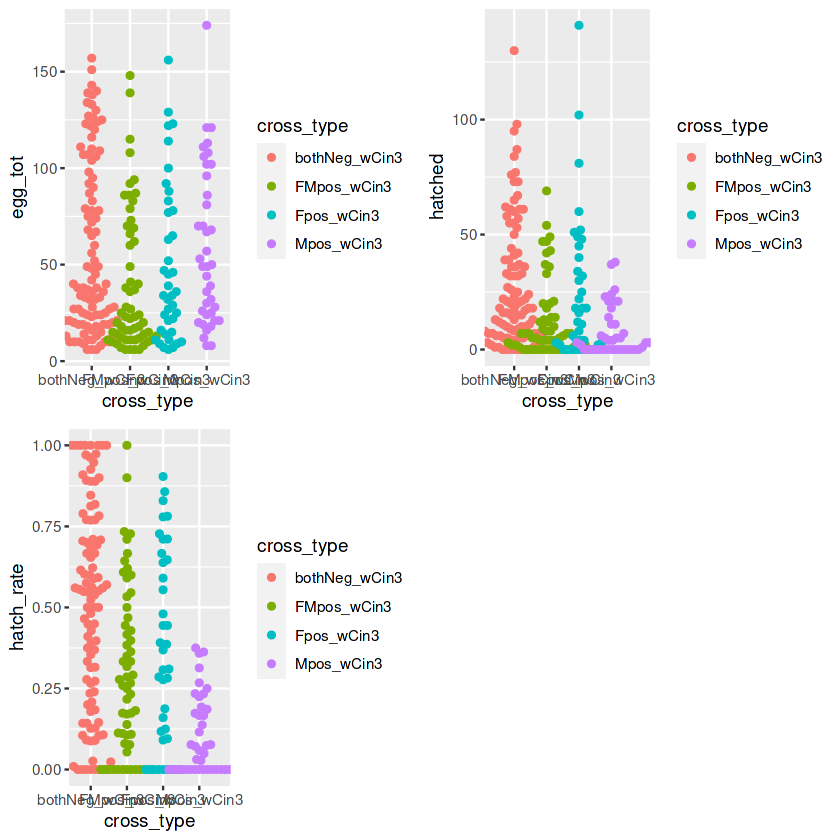

In [5]:
d.usa <- read.csv("crossing_assay_data_usa.csv", header = T, sep = ",")
#d.usa.parental <- d.usa %>% filter(cross.type == "parental")
#d.usa.hybrid <- d.usa %>% filter(cross.type == "hybrid")
d.usa %>%  group_by(pop) %>% dplyr::summarize(Mean = mean(hatch_rate, na.rm=TRUE))

d.usa <- d.usa %>% add_column(continent = "usa")
#d.usa <- d.usa %>% drop_na()
#d.usa <- d.usa %>% subset(pop != "different")

d.usa <- d.usa %>% 
    mutate(cross_type = case_when(population_F != "SW" & population_M != "SW" ~ "bothNeg_wCin3" , # both tests: group A
                                  population_F != "SW" & population_M == "SW" ~ "Mpos_wCin3",
                                  population_F == "SW" & population_M != "SW" ~ "Fpos_wCin3",
                                  population_F == "SW" & population_M == "SW" ~ "FMpos_wCin3"
    ))

d.usa.egg.filter <- d.usa %>% filter(egg_tot > 5)

ENP.usa <- ggplot(d.usa.egg.filter, aes(x = cross_type, y = egg_tot, color = cross_type)) + geom_beeswarm(cex = 3)
HRP.usa <- ggplot(d.usa.egg.filter, aes(x = cross_type, y = hatch_rate, color = cross_type)) + geom_beeswarm(cex = 3)
HNP.usa <- ggplot(d.usa.egg.filter, aes(x = cross_type, y = hatched, color = cross_type)) + geom_beeswarm(cex = 3)
plot_grid(ENP.usa, HNP.usa, HRP.usa)

In [6]:
d.eu <- d.eu %>%
    mutate(population_F = as.character(population_F), population_M = as.character(population_M), id = as.character(id)) %>%
    type_convert(cols(population_F = "c", population_M = "c", id = "c")) %>% as_tibble()

d <- bind_rows(d.eu, d.usa)

a <- d |> group_by(cross_type, continent, pop) |> summarise(egg_tot = sum(egg_tot))
b <- d |> group_by(cross_type, continent, pop) |> count(cross_type)

`summarise()` has grouped output by 'cross_type', 'continent'. You can override
using the `.groups` argument.


In [5]:
#datalist = readRDS("modeldatasets_test.RDS")
b2.1 <- datalist$b2.1
b2.2 <- datalist$b2.2
b2.3 <- datalist$b2.3

Warning message:
“
254 (62.1%) p_waic estimates greater than 0.4. We recommend trying loo instead.”


     elpd_diff se_diff elpd_waic se_elpd_waic p_waic se_p_waic waic   se_waic
b2.1    0.0       0.0  -691.9      24.9        152.2    4.5    1383.8   49.7 
b2.2   -1.3       1.2  -693.2      24.9        152.8    4.5    1386.4   49.8 
b2.3   -1.5       1.4  -693.4      24.9        153.3    4.6    1386.9   49.8 


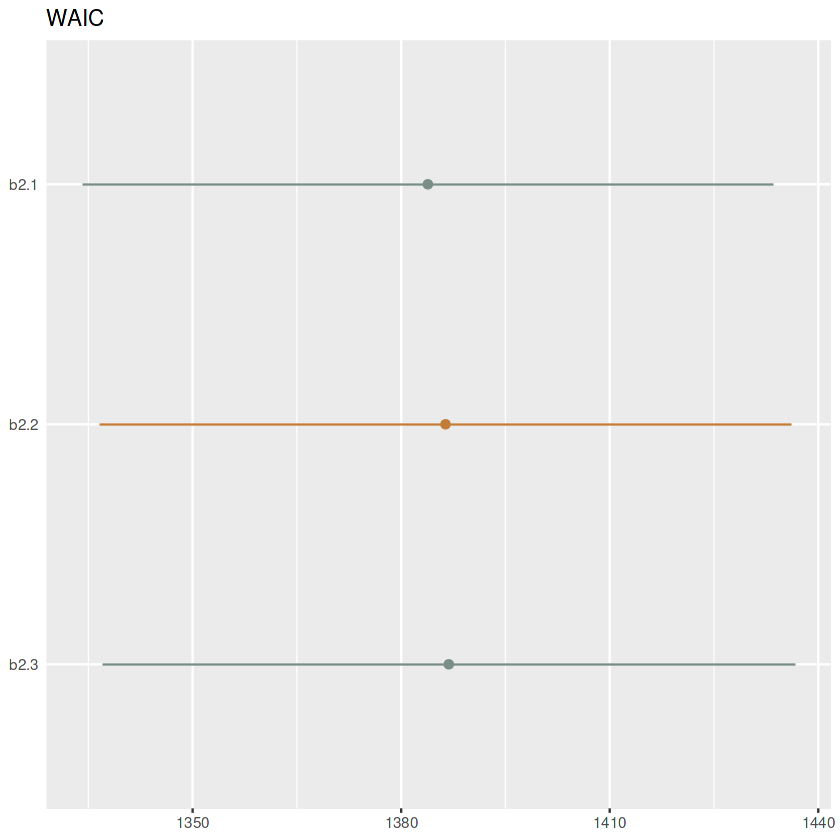

In [15]:
b2.1 <- add_criterion(b2.1, "waic")
b2.2 <- add_criterion(b2.2, "waic")
b2.3 <- add_criterion(b2.3, "waic")

w <- loo_compare(b2.1, b2.2, b2.3, criterion = "waic")

print(w, simplify = F)

w %>% 
  data.frame() %>% 
  rownames_to_column(var = "model") %>%
  
  ggplot(aes(x = reorder(model, -waic), 
             y    = waic,
             ymin = waic - se_waic,
             ymax = waic + se_waic,
             color = model)) +
  geom_pointrange(shape = 16, show.legend = F) +
  scale_color_manual(values = wes_palette("Moonrise2")[c(1, 2, 1, 1, 1, 2)]) +
  coord_flip() +
  labs(x = NULL, y = NULL,
       title = "WAIC") +
  theme(axis.ticks.y    = element_blank())

Setting all 'trials' variables to 1 by default if not specified otherwise.



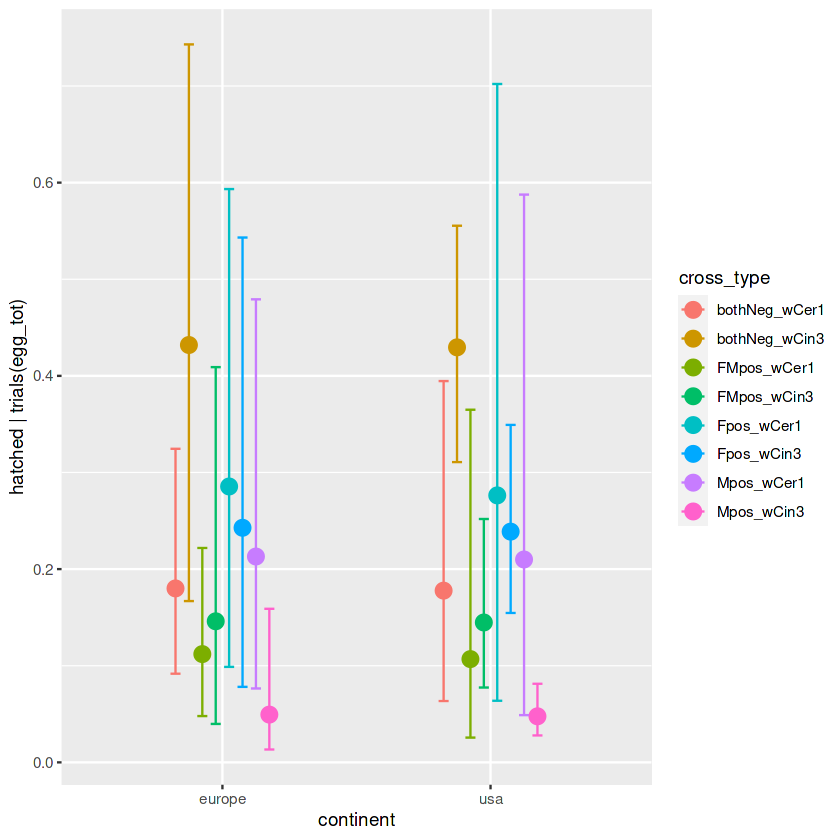

In [16]:
continent <- data.frame(continent = c("europe", "usa"))
condition <- data.frame(continent = c("europe", "usa"))
condition_continent <- data.frame(continent = c("europe", "usa"), pop = c("same", "different"))
condition_pop <- data.frame(pop = c("same", "different"))
condition_type <- data.frame(cross_type = c("same", "different"))

conditional_effects(b2.1, effects = "continent:cross_type", prob = 0.89, points = T)
#conditional_effects(b2.1, effects = "pop", prob = 0.89, points = T)

Warning message:
“Method 'posterior_samples' is deprecated. Please see ?as_draws for recommended alternatives.”


Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


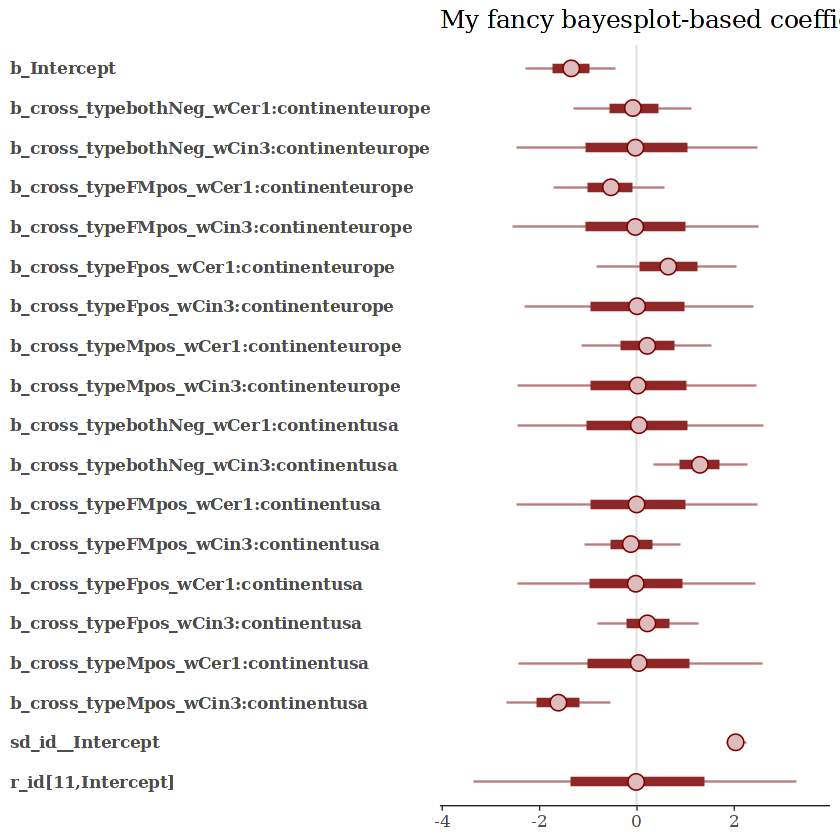

In [17]:
post <- posterior_samples(b2.2)

color_scheme_set("red")
mcmc_intervals(post[, 1:19], 
               prob = .5,
               point_est = "median") +
  labs(title = "My fancy bayesplot-based coefficient plot") +
  theme(axis.text.y  = element_text(hjust = 0),
        axis.line.x  = element_line(size = 1/4),
        axis.line.y  = element_blank(),
        axis.ticks.y = element_blank())

In [5]:
#as_draws_df(b2.2) %>% colnames()
col_pickup <- c('b_Intercept','b_cross_typebothNeg_wCin3','b_cross_typeFMpos_wCer1','b_cross_typeFMpos_wCin3','b_cross_typeFpos_wCer1','b_cross_typeFpos_wCin3','b_cross_typeMpos_wCer1','b_cross_typeMpos_wCin3')
post2.1 <- as_draws_df(b2.1) %>% #select(all_of(col_pickup)) %>% 
pivot_longer(col_pickup[2:length(col_pickup)])%>%
  mutate(continent = case_when(
    endsWith(name, "europe") ~ "europe",
    endsWith(name, "usa") ~ "usa"
    )) %>%
  mutate(cross_type= case_when(
    startsWith(name, "b_cross_typebothNeg") ~ "bothNeg",
    startsWith(name, "b_cross_typeFMpos") ~ "FMpos",
    startsWith(name, "b_cross_typeFpos") ~ "Fpos",
    startsWith(name, "b_cross_typeMpos") ~ "Mpos"
    )) %>%
  mutate(strain = case_when(
    grepl("*wCer1*", name) ~ "wCer1",
    grepl("*wCin3*", name) ~ "wCin3"
  ))


Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


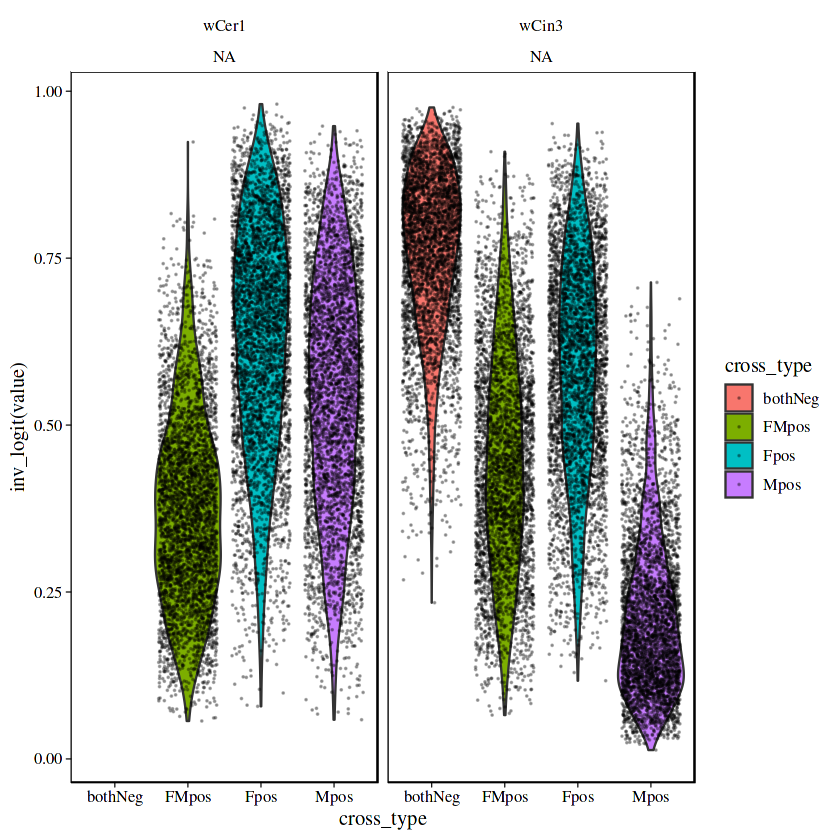

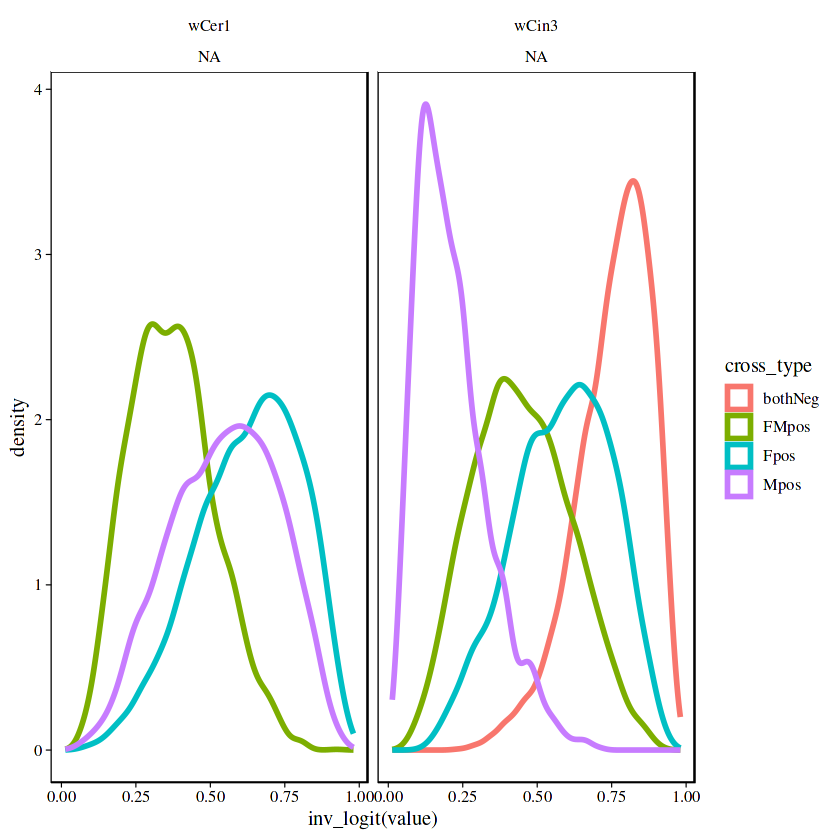

In [6]:
ggplot(data = post2.1, aes(x=cross_type, y=inv_logit(value), fill=cross_type)) +
    geom_violin() + 
    geom_jitter(color="black", size=0.004, alpha=0.3) + #geom_beeswarm(data = d, aes(x=cross_type, y=hatched/egg_tot, size = egg_tot), color = "red", cex= 3) +
    facet_wrap(~strain*continent, ncol = 2)

ggplot(data = post2.1, aes(x = inv_logit(value), color=cross_type)) +
  geom_density(lwd = 1.2, linetype = 1, alpha = 0.9) + facet_wrap(~strain*continent, ncol = 2)
  #scale_color_manual(values = cols)

In [6]:
#col_pickup <- c('b_Intercept','b_cross_typebothNeg_wCer1:continenteurope','b_cross_typebothNeg_wCin3:continenteurope','b_cross_typeFMpos_wCer1:continenteurope','b_cross_typeFMpos_wCin3:continenteurope','b_cross_typeFpos_wCer1:continenteurope','b_cross_typeFpos_wCin3:continenteurope','b_cross_typeMpos_wCer1:continenteurope','b_cross_typeMpos_wCin3:continenteurope','b_cross_typebothNeg_wCer1:continentusa','b_cross_typebothNeg_wCin3:continentusa','b_cross_typeFMpos_wCer1:continentusa','b_cross_typeFMpos_wCin3:continentusa','b_cross_typeFpos_wCer1:continentusa','b_cross_typeFpos_wCin3:continentusa','b_cross_typeMpos_wCer1:continentusa','b_cross_typeMpos_wCin3:continentusa')
col_pickup <- c('b_Intercept','b_cross_typebothNeg_wCer1:continenteurope','b_cross_typeFMpos_wCer1:continenteurope','b_cross_typeFpos_wCer1:continenteurope','b_cross_typeMpos_wCer1:continenteurope','b_cross_typebothNeg_wCin3:continentusa','b_cross_typeFMpos_wCin3:continentusa','b_cross_typeFpos_wCin3:continentusa','b_cross_typeMpos_wCin3:continentusa')
post2.2 <- as_draws_df(b2.2) %>% select(all_of(col_pickup)) %>%
pivot_longer(col_pickup[2:length(col_pickup)])%>%
  mutate(continent = case_when(
    endsWith(name, "europe") ~ "europe",
    endsWith(name, "usa") ~ "usa"
    )) %>%
  mutate(cross_type= case_when(
    startsWith(name, "b_cross_typebothNeg") ~ "bothNeg",
    startsWith(name, "b_cross_typeFMpos") ~ "FMpos",
    startsWith(name, "b_cross_typeFpos") ~ "Fpos",
    startsWith(name, "b_cross_typeMpos") ~ "Mpos"
    )) %>%
  mutate(strain = case_when(
    grepl("*wCer1*", name) ~ "wCer1",
    grepl("*wCin3*", name) ~ "wCin3"
  ))

Warning message:
“Dropping 'draws_df' class as required metadata was removed.”


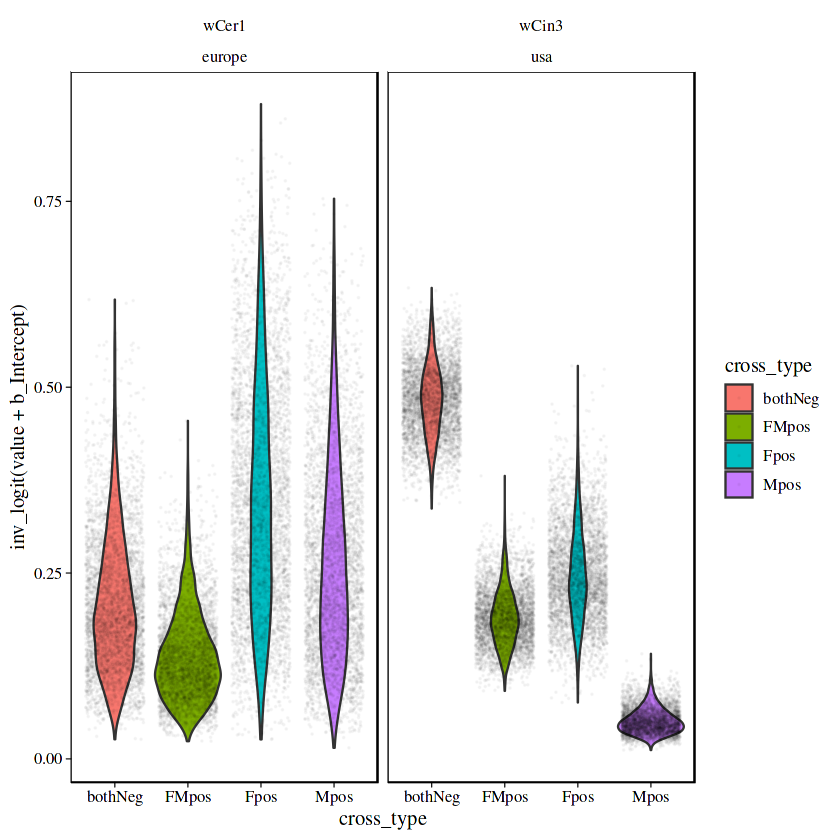

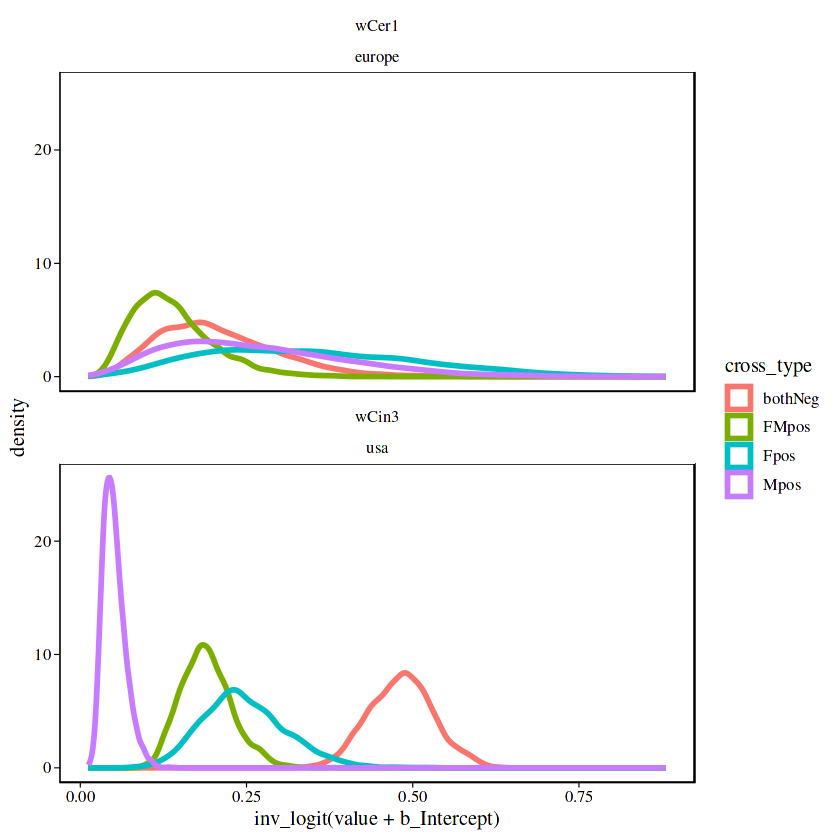

In [7]:
#post <- as_draws_df(b2.2) %>% select(all_of(col_pickup)) %>% 
#pivot_longer(col_pickup) %>% rename(cross_type = name) %>% add_column(data_type = "simulated")
#full <- left_join(post, d)
#full
ggplot(data = post2.2, aes(x=cross_type, y=inv_logit(value+b_Intercept), fill=cross_type)) +
    geom_violin() + 
    geom_jitter(color="black", size=0.004, alpha=0.03) + #geom_beeswarm(data = d, aes(x=cross_type, y=hatched/egg_tot, size = egg_tot), color = "red", cex= 3) +
    facet_wrap(~strain*continent, ncol = 2)

ggplot(data = post2.2, aes(x = inv_logit(value+b_Intercept), color=cross_type)) +
  geom_density(lwd = 1.2, linetype = 1, alpha = 0.9) + facet_wrap(~strain*continent, nrow = 2)
  #scale_color_manual(values = cols)

In [26]:
qe1 <- c(qe1 = "cross_typebothNeg_wCer1:continenteurope + Intercept = cross_typeFMpos_wCer1:continenteurope + Intercept")
qe2 <- c(qe2 = "cross_typebothNeg_wCer1:continenteurope + Intercept  = cross_typeFpos_wCer1:continenteurope + Intercept")
qe3 <- c(qe3 = "cross_typebothNeg_wCer1:continenteurope + Intercept  = cross_typeMpos_wCer1:continenteurope + Intercept")
qe4 <- c(qe4 = "cross_typeFMpos_wCer1:continenteurope + Intercept = cross_typeFpos_wCer1:continenteurope + Intercept")
qe5 <- c(qe5 = "cross_typeFMpos_wCer1:continenteurope + Intercept = cross_typeMpos_wCer1:continenteurope + Intercept")
qe6 <- c(qe6 = "cross_typeFpos_wCer1:continenteurope + Intercept = cross_typeMpos_wCer1:continenteurope + Intercept")

qu1 <- c(qu1 = "cross_typebothNeg_wCin3:continentusa + Intercept = cross_typeFMpos_wCin3:continentusa + Intercept")
qu2 <- c(qu2 = "cross_typebothNeg_wCin3:continentusa + Intercept  = cross_typeFpos_wCin3:continentusa + Intercept")
qu3 <- c(qu3 = "cross_typebothNeg_wCin3:continentusa + Intercept  = cross_typeMpos_wCin3:continentusa + Intercept")
qu4 <- c(qu4 = "cross_typeFMpos_wCin3:continentusa+ Intercept = cross_typeFpos_wCin3:continentusa + Intercept")
qu5 <- c(qu5 = "cross_typeFMpos_wCin3:continentusa + Intercept = cross_typeMpos_wCin3:continentusa + Intercept")
qu6 <- c(qu6 = "cross_typeFpos_wCin3:continentusa + Intercept = cross_typeMpos_wCin3:continentusa + Intercept")

hyp <- hypothesis(b2.2, c(qe1, qe2, qe3, qe4, qe5, qe6, qu1, qu2, qu3, qu4, qu5, qu6))

hyp_table <- hyp$hypothesis %>% slice(rep(1:n(), nrow(hyp$samples)))
hyp_table
hyp_long <- hyp$samples %>% pivot_longer(c(H1, H2, H3, H4, H5, H6, H7, H8, H9, H10, H11, H12))

hyp_long <- cbind(hyp_long, hyp_table)

ggplot(data = hyp_long, aes(x = value, color = name)) +
  geom_density(lwd = 1.2, linetype = 1, alpha = 0.9) +
  facet_wrap(~name)
  #geom_segment(data = hyp_long,
  #             aes(x = CI.Lower	, xend = CI.Upper	, y = 0, yend = value), linetype = "dashed", add = TRUE)


Hypothesis,Estimate,Est.Error,CI.Lower,CI.Upper,Evid.Ratio,Post.Prob,Star
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
qe1,0.4851211,0.7492128,-0.9827831,1.9333057,NA,NA,
qe2,-0.7080023,0.9488963,-2.5722413,1.2523874,NA,NA,
qe3,-0.2838444,0.9078277,-2.0489576,1.5161724,NA,NA,
qe4,-1.1931234,0.9096925,-2.9224847,0.6598482,NA,NA,
qe5,-0.7689655,0.8622893,-2.4055172,0.8934541,NA,NA,
qe6,0.4241579,1.0265473,-1.5640719,2.4058044,NA,NA,
qu1,1.4005623,0.3094509,0.8177896,2.0204149,NA,NA,*
qu2,1.0735557,0.3828159,0.3434818,1.8423977,NA,NA,*
qu3,2.9114866,0.3995155,2.1206713,3.6874231,NA,NA,*


In [19]:
cbind(hyp_long, hyp_table)

name,value,Hypothesis,Estimate,Est.Error,CI.Lower,CI.Upper,Evid.Ratio,Post.Prob,Star
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
H1,1.5832625756,qe1,0.4851211,0.7492128,-0.9827831,1.9333057,NA,NA,
H2,-0.0008431941,qe2,-0.7080023,0.9488963,-2.5722413,1.2523874,NA,NA,
H3,0.4530335817,qe3,-0.2838444,0.9078277,-2.0489576,1.5161724,NA,NA,
H4,-1.5841057697,qe4,-1.1931234,0.9096925,-2.9224847,0.6598482,NA,NA,
H5,-1.1302289939,qe5,-0.7689655,0.8622893,-2.4055172,0.8934541,NA,NA,
H6,0.4538767758,qe6,0.4241579,1.0265473,-1.5640719,2.4058044,NA,NA,
H7,1.3798898525,qu1,1.4005623,0.3094509,0.8177896,2.0204149,NA,NA,*
H8,1.1138493442,qu2,1.0735557,0.3828159,0.3434818,1.8423977,NA,NA,*
H9,2.8523390363,qu3,2.9114866,0.3995155,2.1206713,3.6874231,NA,NA,*
